In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from resources import load_data, custom_k_fold_split, standardize_data
from tqdm import tqdm

def fit_and_evaluate_model(model, X, y, metric: str = 'f1'):
    metric_ = []
    for fold in custom_k_fold_split(X, y, method='individual'):
        X_train, X_test, y_train, y_test = fold
        X_train, X_test = standardize_data(X_train, X_test)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        if metric == 'accuracy':
            metric_.append(accuracy_score(y_test, predictions))
        elif metric == 'f1':
            metric_.append(f1_score(y_test, predictions, average='weighted', zero_division=0))

    return metric_

def custom_resample(num_iterations, n_samples):
    sets = []
    for i in range(num_iterations):
        df = pd.read_csv('data/HR_data.csv', index_col=0).reset_index(drop=True)
        df.sample(n_samples, replace=True).to_csv('data/HR_data_bootstrapped.csv', index=False)
        X, y = load_data('data/HR_data_bootstrapped.csv')
        sets.append((X, y))
    return sets

def no_resample():
    X, y = load_data('data/HR_data.csv')
    return [(X, y)]

def bootstrap_evaluation(model, sets, metric: str = 'f1'):
    bootstrap_results = {
        'metric': []
    }

    for X, y in tqdm(sets, desc=str(model).split('.')[-1].split("\'")[0]):
        model_ = model()
        metric_ = fit_and_evaluate_model(model_, X, y, metric=metric)
        bootstrap_results['metric'].append(metric_)

    list_of_metrics = []           
    for round in bootstrap_results['metric']:
        for val in round:
            list_of_metrics.append(val)
    # returns accuracy, precision, recall
    return list_of_metrics

Baseline: 100%|██████████| 10/10 [00:00<00:00, 21.26it/s]


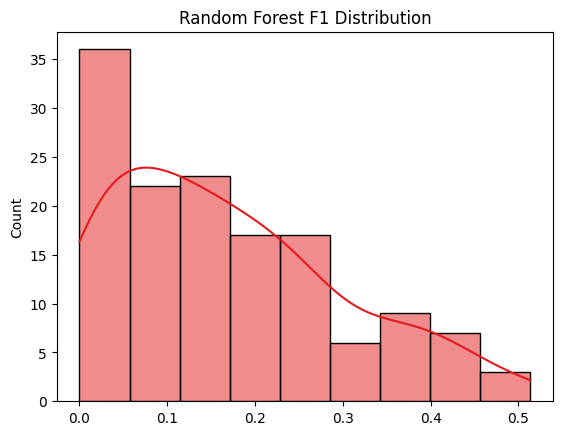

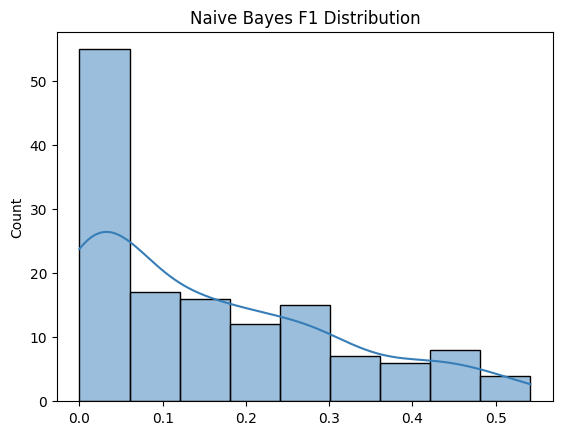

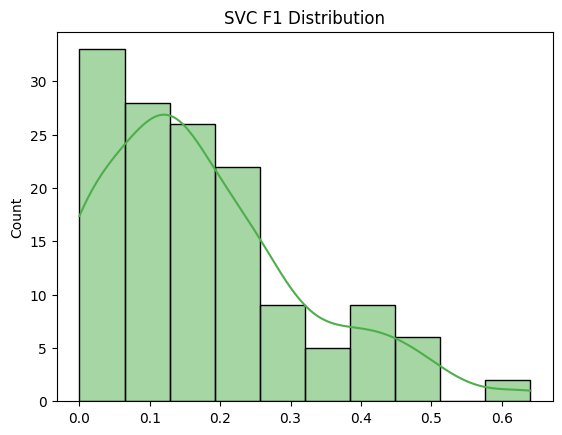

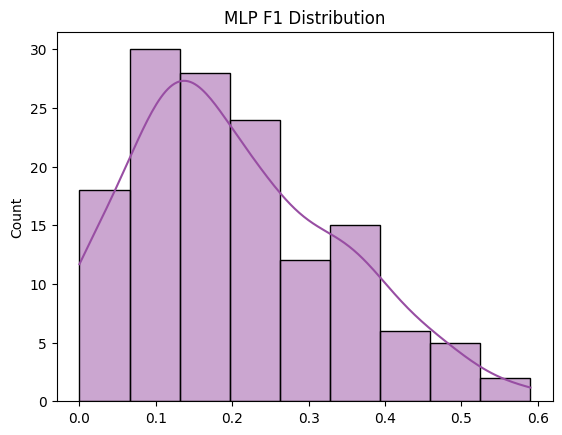

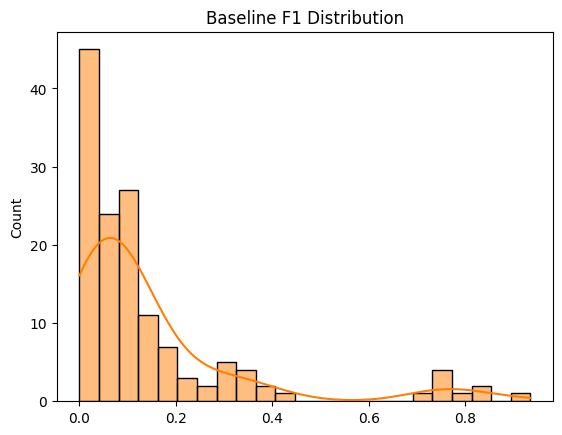

Random Forest Naive Bayes SVC MLP Baseline
0.16856110170876012 0.15553317343724002 0.172941958692075 0.20074439999470325 0.14489681977528088


In [3]:
from models import Baseline
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

_METRIC_ = 'f1'

data = custom_resample(10, 1000)

acc = bootstrap_evaluation(RandomForestClassifier, data, metric=_METRIC_)
nb_acc = bootstrap_evaluation(GaussianNB, data, metric=_METRIC_)
svc_acc = bootstrap_evaluation(SVC, data, metric=_METRIC_)
nn_acc = bootstrap_evaluation(lambda: MLPClassifier(max_iter=1000), data, metric=_METRIC_)
base_acc = bootstrap_evaluation(Baseline, data, metric=_METRIC_)
models = ['Random Forest', 'Naive Bayes', 'SVC', 'MLP','Baseline']
metrics = [acc, nb_acc, svc_acc, nn_acc, base_acc]

import seaborn as sns
import matplotlib.pyplot as plt

colors = sns.color_palette('Set1', n_colors=5)
for model, metric, color in zip(models, metrics, colors):
    sns.histplot(metric, color=color, kde=True, label=model)
    plt.title(f'{model} {_METRIC_.capitalize()} Distribution')
    plt.savefig(f'plots/{model}_{_METRIC_}_dist.png')
    plt.show()

print('Random Forest', 'Naive Bayes', 'SVC', 'MLP','Baseline')
print(np.mean(acc), np.mean(nb_acc), np.mean(svc_acc), np.mean(nn_acc), np.mean(base_acc))

import pickle
for model, metric in zip(models, metrics):
    with open(f'metrics/{model}.pkl', 'wb') as f:
        pickle.dump(metric, f)

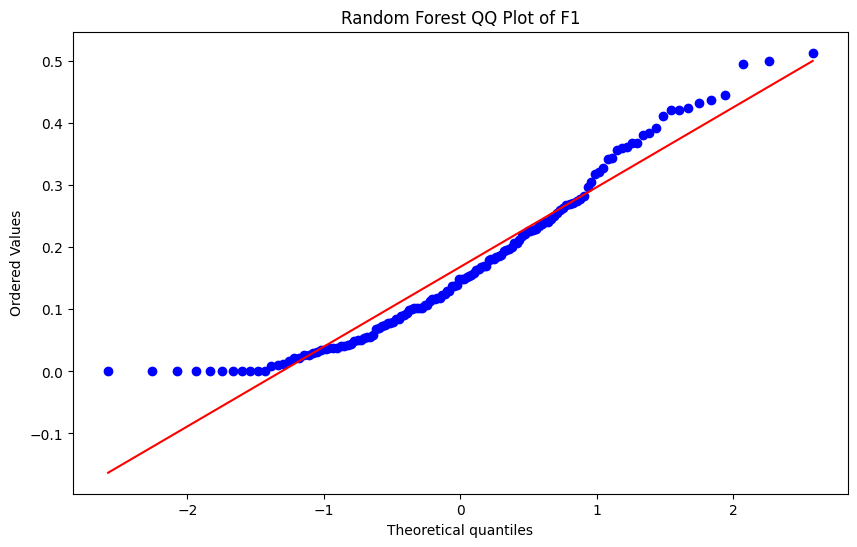

Shapiro-Wilk Test Statistic: 0.935171587286723
Shapiro-Wilk Test p-value: 4.688913512478007e-06
The data is not normally distributed (reject H0)


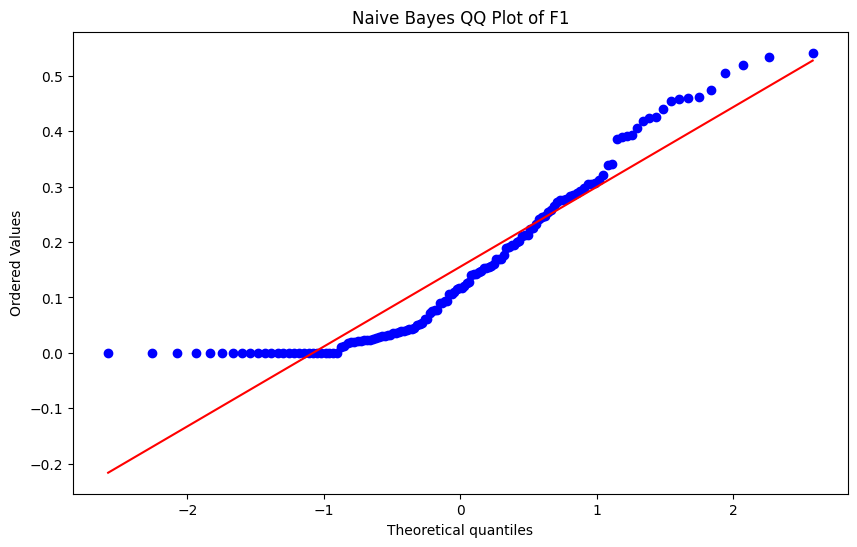

Shapiro-Wilk Test Statistic: 0.8838694459456611
Shapiro-Wilk Test p-value: 4.518183272218017e-09
The data is not normally distributed (reject H0)


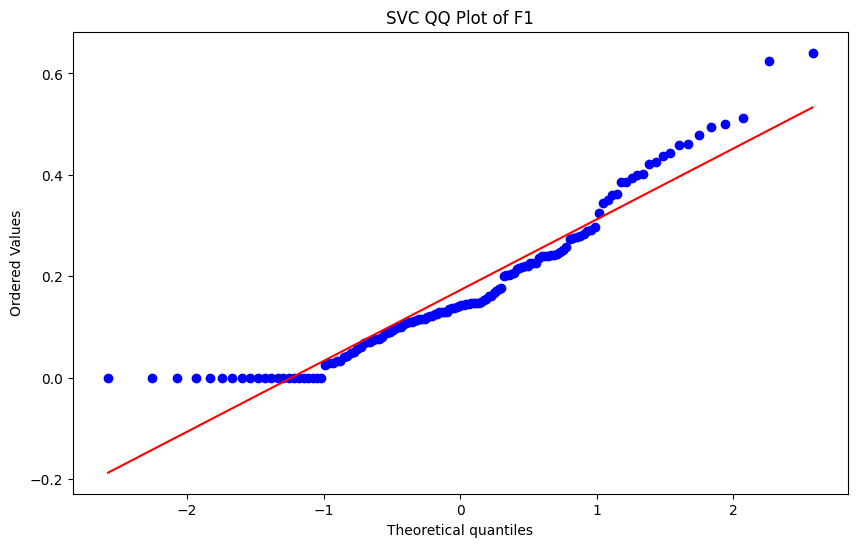

Shapiro-Wilk Test Statistic: 0.9166690375352673
Shapiro-Wilk Test p-value: 2.8935756544452506e-07
The data is not normally distributed (reject H0)


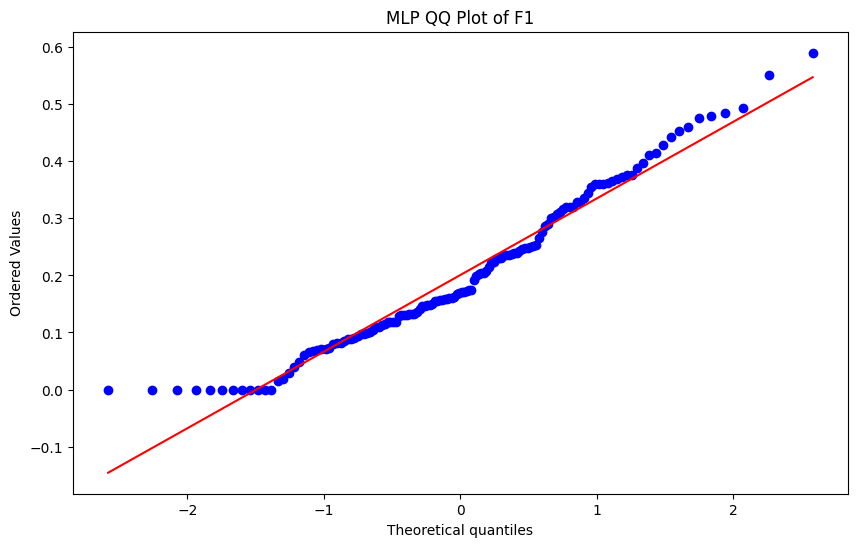

Shapiro-Wilk Test Statistic: 0.9597100219769429
Shapiro-Wilk Test p-value: 0.0003944809963309447
The data is not normally distributed (reject H0)


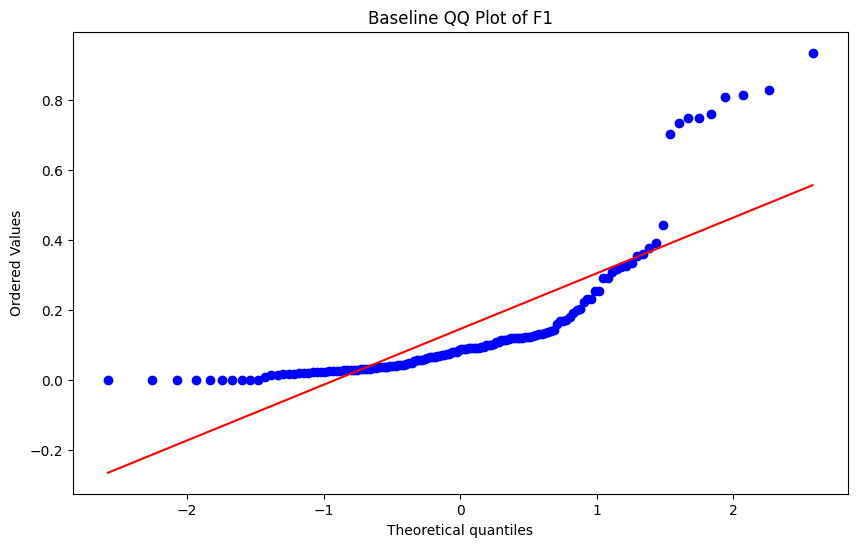

Shapiro-Wilk Test Statistic: 0.6619623377059431
Shapiro-Wilk Test p-value: 1.6565396763106884e-16
The data is not normally distributed (reject H0)


In [4]:
from scipy import stats

for model, metric in zip(models, metrics):
    # QQ Plot
    plt.figure(figsize=(10, 6))
    stats.probplot(metric, dist="norm", plot=plt)
    plt.title(f"{model} QQ Plot of {_METRIC_.capitalize()}")
    plt.savefig(f'plots/{model}_qqplot.png')
    plt.show()

    # Shapiro-Wilk Test
    shapiro_test = stats.shapiro(metric)
    print("Shapiro-Wilk Test Statistic:", shapiro_test.statistic)
    print("Shapiro-Wilk Test p-value:", shapiro_test.pvalue)

    # Interpretation
    if shapiro_test.pvalue > 0.05:
        print("The data is normally distributed (fail to reject H0)")
    else:
        print("The data is not normally distributed (reject H0)")

In [5]:
from scipy.stats import kruskal

# Example accuracies from three models


# Kruskal-Wallis H Test
kruskal_test = kruskal(*metrics)
print("Kruskal-Wallis H Test Statistic:", kruskal_test.statistic)
print("Kruskal-Wallis H Test p-value:", kruskal_test.pvalue)

# Interpretation
if kruskal_test.pvalue > 0.05:
    print("No significant difference between the models (fail to reject H0)")
else:
    print("Significant difference between the models (reject H0)")


Kruskal-Wallis H Test Statistic: 29.628485322286522
Kruskal-Wallis H Test p-value: 5.825115718292057e-06
Significant difference between the models (reject H0)


In [6]:
from scipy.stats import wilcoxon

p_val_matrix = np.zeros((5, 5))

for model, metric in zip(models, metrics):

    for model2, metric2 in zip(models, metrics):
        if model == model2:
            continue

        print(f"Comparing {model} and {model2}")

        # Wilcoxon Signed-Rank Test
        wilcoxon_test = wilcoxon(metric, metric2)
        print("Wilcoxon Test Statistic:", wilcoxon_test.statistic)
        print("Wilcoxon Test p-value:", wilcoxon_test.pvalue)

        # Interpretation
        if wilcoxon_test.pvalue > 0.05:
            print("No significant difference between the two models (fail to reject H0)")
        else:
            print("Significant difference between the two models (reject H0)")
        print('\n')
        p_val_matrix[models.index(model), models.index(model2)] = wilcoxon_test.pvalue


Comparing Random Forest and Naive Bayes
Wilcoxon Test Statistic: 4655.0
Wilcoxon Test p-value: 0.5602832369895967
No significant difference between the two models (fail to reject H0)


Comparing Random Forest and SVC
Wilcoxon Test Statistic: 3678.0
Wilcoxon Test p-value: 0.6232466304034336
No significant difference between the two models (fail to reject H0)


Comparing Random Forest and MLP
Wilcoxon Test Statistic: 3250.0
Wilcoxon Test p-value: 0.0032505430068803776
Significant difference between the two models (reject H0)


Comparing Random Forest and Baseline
Wilcoxon Test Statistic: 3158.0
Wilcoxon Test p-value: 0.0002187710294708403
Significant difference between the two models (reject H0)


Comparing Naive Bayes and Random Forest
Wilcoxon Test Statistic: 4655.0
Wilcoxon Test p-value: 0.5602832369895967
No significant difference between the two models (fail to reject H0)


Comparing Naive Bayes and SVC
Wilcoxon Test Statistic: 4447.0
Wilcoxon Test p-value: 0.3100694348907449
No sig

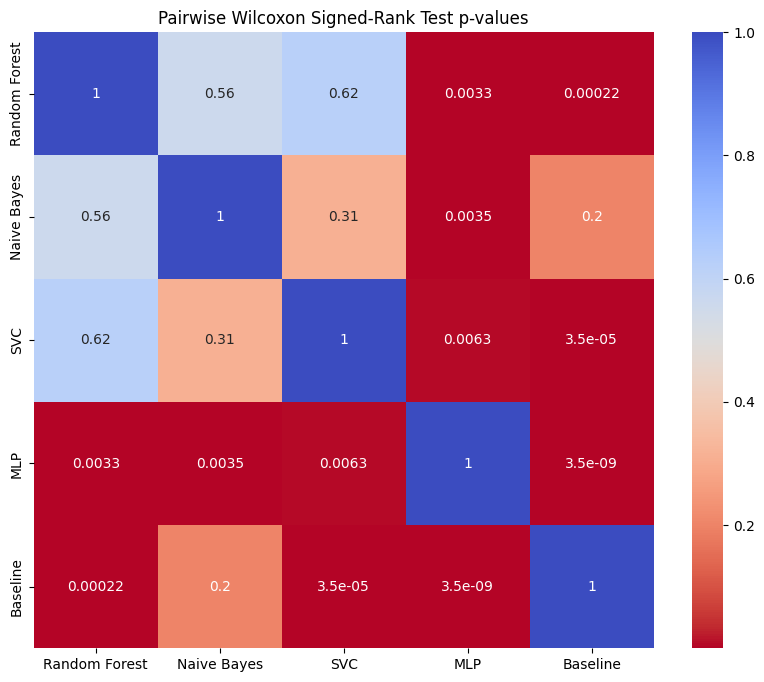

In [7]:
# Initialize p-value matrix
p_val_matrix = np.ones((len(models), len(models))) 

# Compute pairwise Wilcoxon Signed-Rank Test
for i, metric in enumerate(metrics):
    for j, metric2 in enumerate(metrics):
        if i == j:
            continue
        wilcoxon_test = wilcoxon(metric, metric2)
        p_val_matrix[i, j] = wilcoxon_test.pvalue

# Visualize p-value matrix with heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_val_matrix, xticklabels=models, yticklabels=models, annot=True, cmap='coolwarm_r', cbar=True)
plt.title('Pairwise Wilcoxon Signed-Rank Test p-values')
plt.savefig('plots/pairwise_wilcoxon_pvalues.png')
plt.show()

In [13]:
mean_metrics = [np.mean(m) for m in metrics]
std_metrics = [np.std(m) for m in metrics]
df = pd.DataFrame(np.array([mean_metrics, std_metrics]).T, index=models, columns=[f'Mean {_METRIC_.capitalize()}', 'Standard Deviation'])
df

,Mean F1,Standard Deviation
Random Forest,0.168561,0.130611
Naive Bayes,0.155533,0.150521
SVC,0.172942,0.143330
MLP,0.200744,0.134747
Baseline,0.144897,0.193193


Model: Random Forest
95% Confidence Interval: [0.147, 0.190]


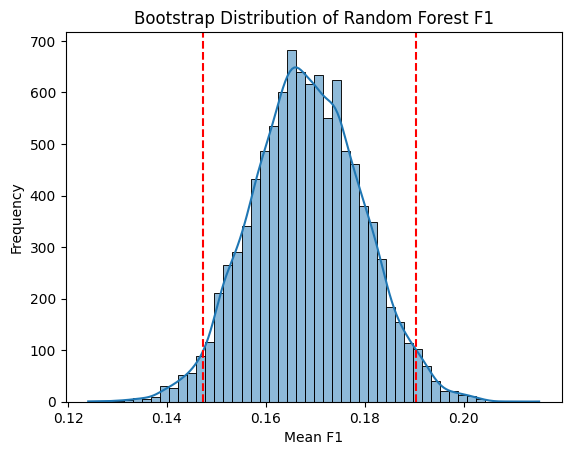

C:\Users\pvest\AppData\Local\Temp\ipykernel_21216\172590787.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ci_df = pd.concat([ci_df, confidence_intervals])


Model: Naive Bayes
95% Confidence Interval: [0.131, 0.180]


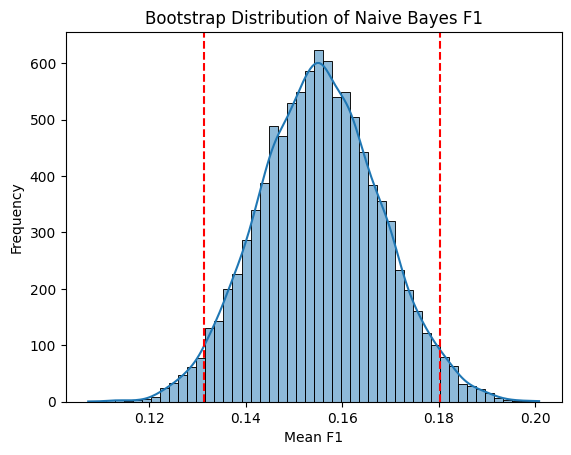

Model: SVC
95% Confidence Interval: [0.150, 0.196]


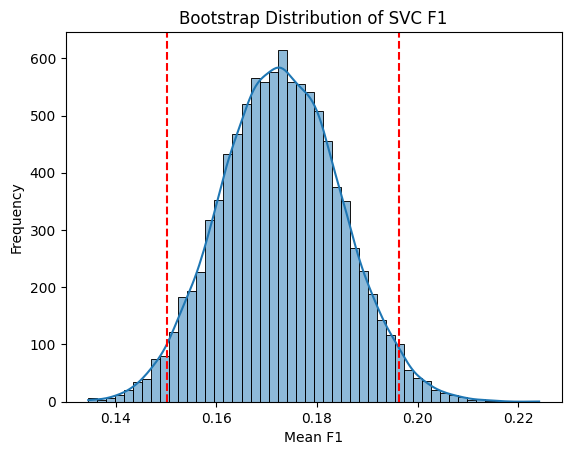

Model: MLP
95% Confidence Interval: [0.179, 0.223]


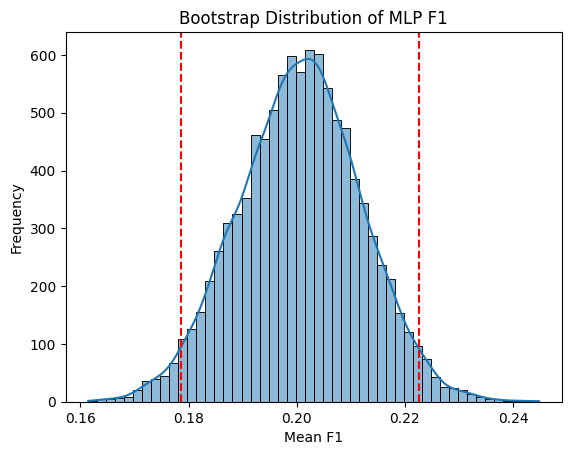

Model: Baseline
95% Confidence Interval: [0.115, 0.178]


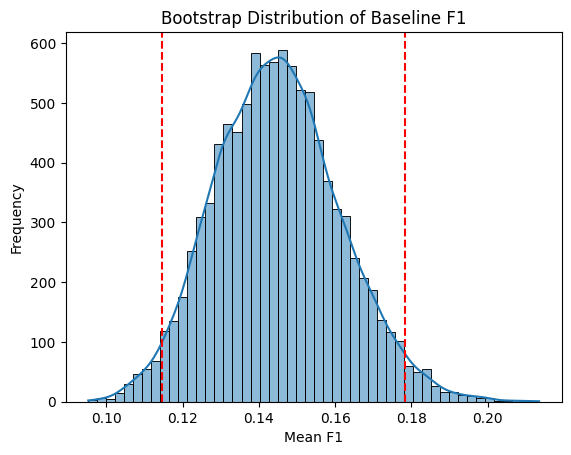

,Mean F1,Standard Deviation
Random Forest,0.168561,0.130611
Naive Bayes,0.155533,0.150521
SVC,0.172942,0.143330
MLP,0.200744,0.134747
Baseline,0.144897,0.193193


,Lower Bound,Upper Bound,Mean,Standard Deviation
Model,,,,
Random Forest,0.147231,0.190316,0.168561,0.130611
Naive Bayes,0.131399,0.180351,0.155533,0.150521
SVC,0.150096,0.196351,0.172942,0.143330
MLP,0.178550,0.222525,0.200744,0.134747
Baseline,0.114689,0.178441,0.144897,0.193193


In [19]:
ci_df = pd.DataFrame(columns=['Model', 'Lower Bound', 'Upper Bound', 'Mean', 'Standard Deviation'])

for metric, model in zip(metrics, models):
    ## Number of bootstrap samples
    n_bootstraps = 10_000
    bootstrapped_accuracies = []

    # Perform bootstrap sampling
    for _ in range(n_bootstraps):
        bootstrapped_sample = np.random.choice(metric, size=len(metric), replace=True)
        bootstrapped_accuracies.append(np.mean(bootstrapped_sample))

    # Calculate confidence intervals
    alpha = 0.95
    lower_bound = np.percentile(bootstrapped_accuracies, (1 - alpha) / 2 * 100)
    upper_bound = np.percentile(bootstrapped_accuracies, (1 + alpha) / 2 * 100)

    # Print confidence intervals
    print(f"Model: {model}")
    print(f"95% Confidence Interval: [{lower_bound:.3f}, {upper_bound:.3f}]")

    # Visualization of the bootstrap distribution and confidence interval
    sns.histplot(bootstrapped_accuracies, bins=50, kde=True)
    plt.axvline(lower_bound, color='red', linestyle='--')
    plt.axvline(upper_bound, color='red', linestyle='--')
    plt.title(f'Bootstrap Distribution of {model} {_METRIC_.capitalize()}')
    plt.xlabel(f'Mean {_METRIC_.capitalize()}')
    plt.ylabel('Frequency')
    plt.show()

    confidence_intervals = pd.DataFrame({
        'Model': [model],
        'Lower Bound': [lower_bound],
        'Upper Bound': [upper_bound],
        'Mean': [np.mean(metric)],
        'Standard Deviation': [np.std(metric)]
    })

    ci_df = pd.concat([ci_df, confidence_intervals])



ci_df = ci_df.set_index('Model')

display(df)
ci_df